# 1. Test the model data loading, training & evaluation

In [72]:
%load_ext autoreload
%autoreload 2

import os
import yaml
from tqdm import tqdm

import numpy as np
import pandas as pd
import yaml
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

from LightningModules.Models.interaction_gnn import InteractionGNN
from pytorch_lightning.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.1 Setup a model

In [2]:
config = "small_train_fc.yaml"
with open(config, "r") as f:
    config = yaml.safe_load(f)

In [3]:
model = InteractionGNN(config)

In [4]:
model.setup("fit")

Loading trainset with 10000 files


100%|██████████| 1/1 [00:10<00:00, 10.66s/it]


Loading valset with 90000 files


100%|██████████| 1/1 [00:11<00:00, 11.69s/it]

Loading testset with 0 files
Defining figures of merit
Mon Jan 16 12:52:27 2023


In [8]:
from torch_geometric.data import DataLoader

train_loader = model.train_dataloader()

for batch in train_loader:
    print(batch)
    break

DataBatch(x=[12122, 5], y=[1000], edge_index=[2, 139546], batch=[12122], ptr=[1001])


## 1.2 Try a Training Loop

In [4]:
logger = WandbLogger(project=config["project"], group="InitialTest", save_dir=config["artifacts"])
logger.watch(model)
checkpoint_callback = ModelCheckpoint(
    dirpath=config["artifacts"],
    filename='best',
    monitor="inv_eps",
    mode="max",
    save_top_k=1,
    save_last=True
)
trainer = Trainer(gpus=1, max_epochs=config["max_epochs"], logger=logger, callbacks=[checkpoint_callback])
trainer.fit(model)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: murnanedaniel. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading trainset with 400000 files


100%|██████████| 5/5 [01:04<00:00, 12.89s/it]


Loading valset with 200000 files


100%|██████████| 2/2 [00:32<00:00, 16.15s/it]


Loading testset with 0 files
Defining figures of merit
Mon Jan 16 14:00:35 2023


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | node_encoder   | Sequential | 34.6 K
1 | edge_encoder   | Sequential | 66.9 K
2 | edge_network   | Sequential | 83.3 K
3 | node_network   | Sequential | 66.9 K
4 | output_network | Sequential | 51.2 K
----------------------------------------------
302 K     Trainable params
0         Non-trainable params
302 K     Total params
1.212     Total estimated model params size (MB)


Epoch 42:  78%|███████▊  | 47/60 [00:35<00:09,  1.32it/s, loss=0.0127, v_num=ak8m]

## 1.3 Evaluate the trained model

In [3]:
config = "small_train_fc.yaml"
with open(config, "r") as f:
    config = yaml.safe_load(f)

In [10]:
checkpoint_path = os.path.join(config["artifacts"], "best-v1.ckpt")
model = InteractionGNN.load_from_checkpoint(checkpoint_path=checkpoint_path, config=config)

In [11]:
model.setup("fit")

Loading trainset with 400000 files


100%|██████████| 5/5 [01:05<00:00, 13.03s/it]


Loading valset with 200000 files


100%|██████████| 2/2 [00:27<00:00, 13.75s/it]

Loading testset with 0 files
Defining figures of merit
Mon Jan 16 14:43:46 2023


In [12]:
model = model.to("cuda")

In [73]:
outputs = []
targets = []

with torch.no_grad():
    model.eval()
    for batch in tqdm(model.val_dataloader()):
        out = model.validation_step(batch.to("cuda"), 0)
        outputs.append(out["outputs"])
        targets.append(out["targets"])

outputs = torch.cat(outputs)
targets = torch.cat(targets)

100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


In [15]:
out

{'loss': tensor(0.5235, device='cuda:0'),
 'outputs': tensor([-3.7462, -4.1448, -4.2063,  ..., -3.9899, -4.2682, -4.1276],
        device='cuda:0'),
 'targets': tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0'),
 'acc': 0.9988,
 'auc': 0.9988152449606194,
 'eps': 0.00040048057669203043,
 'eps_eff': 0.5}

In [17]:
out["targets"].bool().sum()

tensor(12, device='cuda:0')

In [18]:
(torch.sigmoid(out["outputs"]) > 0.5).sum()

tensor(14, device='cuda:0')

In [100]:
threshold = 0.05
true = targets.bool()
positive = (torch.sigmoid(outputs) > threshold)
true_positive = true & positive
false_positive = ~true & positive

In [101]:
eff = true_positive.sum() / true.sum()
fake_rate = 1 - (true_positive.sum() / positive.sum())
fpr = false_positive.sum() / (~true).sum()

In [102]:
eff, fake_rate, fpr

(tensor(0.8007, device='cuda:0'),
 tensor(0.6359, device='cuda:0'),
 tensor(0.0019, device='cuda:0'))

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve

In [55]:
true

tensor([False, False, False,  ..., False, False, False], device='cuda:0')

In [56]:
fpr, tpr, threshold = roc_curve(true.float().cpu(), torch.sigmoid(out["outputs"]).cpu())

In [57]:
fpr

array([0.00000000e+00, 0.00000000e+00, 2.00240288e-04, 2.00240288e-04,
       4.00480577e-04, 4.00480577e-04, 7.00841009e-04, 7.00841009e-04,
       1.00120144e-03, 1.00120144e-03, 1.10132159e-03, 1.10132159e-03,
       2.80336404e-03, 2.80336404e-03, 6.50780937e-03, 6.50780937e-03,
       9.73167801e-02, 9.75170204e-02, 2.32579095e-01, 2.32779335e-01,
       2.41990388e-01, 2.42190629e-01, 2.56207449e-01, 2.56407689e-01,
       2.70824990e-01, 2.71025230e-01, 2.92851422e-01, 2.93051662e-01,
       3.13576292e-01, 3.13776532e-01, 3.30897076e-01, 3.31097317e-01,
       3.80256308e-01, 3.80456548e-01, 3.85462555e-01, 3.85662795e-01,
       4.03183821e-01, 4.03384061e-01, 4.08590308e-01, 4.08790549e-01,
       4.37625150e-01, 4.37825390e-01, 4.39727673e-01, 4.39927913e-01,
       4.42030437e-01, 4.42230677e-01, 5.53964758e-01, 5.54164998e-01,
       5.69883861e-01, 5.70084101e-01, 5.78093712e-01, 5.78293953e-01,
       5.80897076e-01, 5.81097317e-01, 6.07529035e-01, 6.07729275e-01,
      

In [58]:
tpr

array([0.        , 0.08333333, 0.08333333, 0.33333333, 0.33333333,
       0.5       , 0.5       , 0.66666667, 0.66666667, 0.75      ,
       0.75      , 0.83333333, 0.83333333, 0.91666667, 0.91666667,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [30]:
threshold

array([1.9995179 , 0.9995179 , 0.998285  , 0.9883309 , 0.831612  ,
       0.76104695, 0.5616015 , 0.45039454, 0.23226316, 0.1717725 ,
       0.13779226, 0.12618683, 0.04722698, 0.04271041, 0.03272723,
       0.03260814, 0.02046704, 0.02046314, 0.01799593, 0.01799346,
       0.01788115, 0.01787939, 0.01771646, 0.0177161 , 0.01757669,
       0.01757386, 0.01732062, 0.01731912, 0.01711868, 0.01711679,
       0.01696805, 0.01696627, 0.01657364, 0.01657338, 0.01653309,
       0.01653094, 0.01636584, 0.01636549, 0.01631884, 0.01631872,
       0.01608351, 0.0160834 , 0.0160682 , 0.0160676 , 0.01604862,
       0.01604771, 0.01525604, 0.01525513, 0.01514533, 0.01514377,
       0.01508951, 0.0150892 , 0.01507571, 0.0150753 , 0.01487251,
       0.01487165, 0.01480943, 0.01480764, 0.01413008, 0.01412937,
       0.0141081 , 0.01410742, 0.01401741, 0.01401322, 0.01371809,
       0.01371784, 0.01342224, 0.01342167, 0.01322768, 0.01322713,
       0.01271692, 0.01271522, 0.01268045, 0.01267735, 0.01210

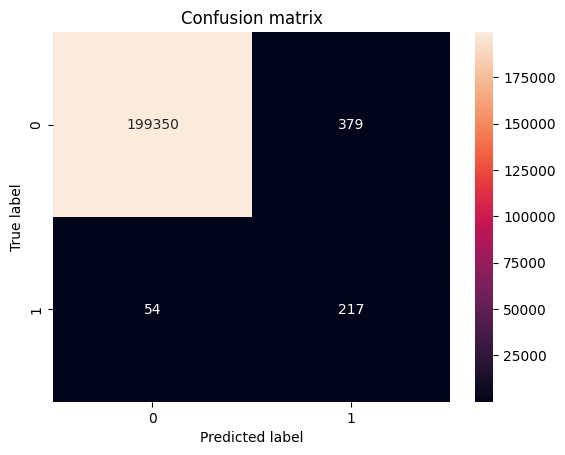

In [103]:
# Make a confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(true.cpu(), positive.cpu())

# Plot it as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()